### 강아지 얼굴 표정 분류하기
당신은 몇일 전 소개팅을 나갔습니다. 상대가 너무 마음에 들었던 나머지 강아지를 좋아한다던 그/그녀에게 당신은 무리수를 던집니다. 

<h3 >저 강아지 표정 보면 다 알아요 ! 😎</h3>
덜컥 그/그녀는 당신에게 고백을 청했고, 당신은 승낙했습니다.

문득 두려워 졌습니다. 매일같이 그/그녀가 강아지 표정을 찍어 보내며 지금은 무슨 감정을 갖고 있는 것인지 물어본다면..

그 때 천운이 따라 한 가게의 플랜 카드를 보게 되는데...

<h3 style="color:yellow;" >잘 훈련된 모델만 제공해주시면 어떤 제품에도 적용해드립니다 !</h3>

이 때 당신의 머리가 번뜩입니다. 강아지의 감정을 분류하는 모델을 만들고 객체 탐지 기능만 적용된다면 안경에다가..?!

필사적인 모델링을 시작합니다.

### 데이터 셋 구성

강아지 표정 4가지에 대한 학습을 진행합니다.

|클래스 분류|라벨값|
|---|---|
|angry|0|
|happy|1|
|relaxed|2|
|sad|3|

### 데이터셋 분할(Kaggle)
현재 캐글에서 받아온 데이터의 디렉터리 구조는 아래와 같습니다.
```
- dog dataset
|_ angry
|_ happy
|_ relaxed
|_ sad
```
각 폴더에 1000개씩의 이미지가 존재하며, 이를 `splitfolders`라는 모듈을 활용해 train, test, validation 셋으로 분할합니다. 분할 된 이후의 구조는 다음과 같이 변경됩니다.

```
- dog dataset
|_ test
|   |__ angry
|   |__ happy
|   |__ relaxed
|   |__ sad
|_ train
|   |__ angry
|   |__ happy
|   |__ relaxed
|   |__ sad
|_ val
|   |__ angry
|   |__ happy
|   |__ relaxed
|___|__ sad
```

In [1]:
import splitfolders # 모듈 임포트

# random seed 고정, ratio를 통해 train:test:validation의 비율을 결정. 8:1:1로 실행.
splitfolders.ratio('./dog_dataset/', './dog_dataset_output', seed=1337, ratio=(0.8, 0.1, 0.1))

Copying files: 0 files [00:00, ? files/s]

Copying files: 3874 files [00:06, 588.41 files/s]


### 라벨값과 함께 파일 이름 수정
현재 angry, happy, relaxed, sad 앞에 라벨을 의미하는 숫자가 없습니다. 직관적으로 볼 수 있게 라벨을 붙인 이름으로 변경합니다.

In [2]:
import os

t = ["train", "test", "val"]
for set_ in t:
    dir_list = os.listdir(f'./dog_dataset_output/{set_}/') # 
    for idx, dir in enumerate(dir_list):
        print(f"{set_}폴더의 {dir}를 {idx}_{dir}로 변경합니다.")
        os.rename(f"./dog_dataset_output/{set_}/{dir}", f"./dog_dataset_output/{set_}/{idx}_{dir}")

train폴더의 angry를 0_angry로 변경합니다.
train폴더의 happy를 1_happy로 변경합니다.
train폴더의 relaxed를 2_relaxed로 변경합니다.
train폴더의 sad를 3_sad로 변경합니다.
test폴더의 angry를 0_angry로 변경합니다.
test폴더의 happy를 1_happy로 변경합니다.
test폴더의 relaxed를 2_relaxed로 변경합니다.
test폴더의 sad를 3_sad로 변경합니다.
val폴더의 angry를 0_angry로 변경합니다.
val폴더의 happy를 1_happy로 변경합니다.
val폴더의 relaxed를 2_relaxed로 변경합니다.
val폴더의 sad를 3_sad로 변경합니다.


### 데이터 1차 전처리
이미지들을 하나씩 보면서 몇 파일을 삭제하는 작업을 진행했습니다.
- 화를 낸다는 기준이 미간이 찌푸려지는 정도가 될 것을 대비하여 happy 및 기타 파일에서 불독 사진은 삭제하였습니다.
- 지나치게 검은 사진들을 삭제했습니다.
- 이외 노이즈가 심한 사진들을 삭제했습니다(선글라스를 쓰고 있는 강아지, 사람이 강아지보다 비중이 큰 경우, 강아지의 입밖에 안보이는 경우)

### 데이터 분포 확인
각 세트 별 데이터 분포에 대해서 확인합니다.

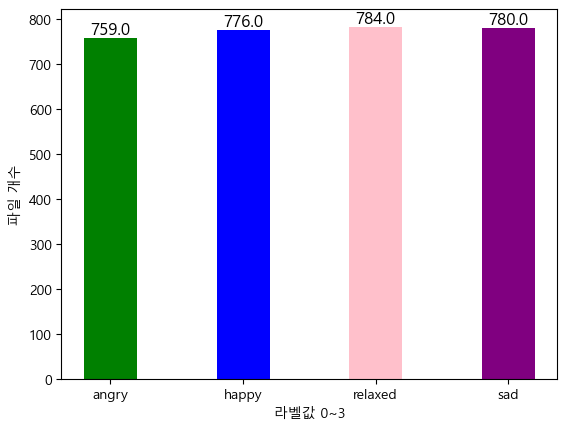

In [3]:
import matplotlib.pyplot as plt, os, matplotlib as mlp
from glob import glob

mlp.rcParams["font.family"] = "Malgun Gothic" # 한글 깨짐 방지

train_path = glob("./dog_dataset_output/train/*")
file_cnt = [len(os.listdir(path)) for path in train_path] # 파일 개수 리스트화
labels = ["angry", "happy", "relaxed", "sad"] # 라벨값

bar = plt.bar(labels, file_cnt, width=0.4, color = ["green", "blue", "pink", "purple"]) # barplot
plt.xlabel("라벨값 0~3")
plt.ylabel("파일 개수")

for rect in bar: # barplot 위에 숫자 표시하기
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width()/2.0, height, '%.1f' % height, ha='center', va='bottom', size = 12)
    
plt.show()

### 하이퍼 파라미터 정의
모델에 사용할 하이퍼 파라미터를 정의합니다.

In [4]:
num_epoch = 100             # 훈련 횟수
batch_size = 5              # 데이터 묶음 단위수
learning_rate = 0.001       # 학습률
dropout_rate = 0.2          # dropout 비율
input_shape = (150, 150, 3) # 입력 이미지 크기
num_class = 4               # 분류 클래스 수

### 이미지 증강처리
데이터 학습 시, 변형 및 증강된 이미지로 학습하기 위해 증강기를 정의합니다.

In [5]:
from keras.preprocessing.image import ImageDataGenerator

train_dir = './dog_dataset_output/train/'
test_dir = "./dog_dataset_output/test/"

train_datagen = ImageDataGenerator(       # train dataset 용 이미지 전처리 과정
    rescale=1./255.,                      # Normalize를 위해 255로 나누어 줌
    width_shift_range=0.3,                # 폭(가로) 쪽으로 30%범위에서 랜덤하게 좌우 시프트 시킴
    zoom_range=0.2,                       # 20%범위에서 랜덤하게 크기를 늘리거나 줄임
    horizontal_flip=True                  # 수평축을 중심으로 이미지를 뒤집음
)

test_datagen = ImageDataGenerator(        # test dataset 용 이미지 전처리 과정
    rescale=1./255.                       # train의 DataGenerator와 같은 크기로 rescale해야 함
)

train_generator = train_datagen.flow_from_directory( 
    train_dir,                      # flow_from_directory이기에 train dataset 경로 입력. 이 때 트리 형태(내부에 클래스별로 분류해 둔 형태)로 있어야함.
    target_size = input_shape[:2],  # 하이퍼 파라미터에서 정의한 변수의 가로 세로 길이만 가져온다.
    batch_size = batch_size,        # batch_size 지정
    color_mode = 'rgb',             # 컬러 파일인 경우, 'rgb' 또는 'rgba'로 설정
    class_mode='categorical'        # 4개의 클래스를 분류하는 문제이기에 categorical로 설정
)                                   

validation_generator = test_datagen.flow_from_directory(
    test_dir,                       # 위와 마찬가지로 트리 형태로 존재해야 함
    target_size=input_shape[:2],    
    batch_size=batch_size,          # 고해상도 사진의 경우 오류를 미연에 방지하기 위해 적은 값으로 설정한다. 4~8정도가 적당하다.
    color_mode='rgb',
    class_mode='categorical'        
) 

Found 3099 images belonging to 4 classes.
Found 389 images belonging to 4 classes.


### 학습 모델(직접 설계 vs 전이학습)
직접 모델층을 구성하여 진행하는 과정과, 전이 학습하는 결과를 비교합니다.

In [6]:
from keras import layers, models
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, CSVLogger
import tensorflow as tf
import matplotlib as mlp, matplotlib.pyplot as plt
import pandas as pd

# 직접 빌드
def create_my_cnn():
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation="relu", input_shape = input_shape))
    model.add(layers.MaxPooling2D(2, 2)) # stride를 지정하지 않을 경우, 커널 사이즈로 자동 지정됨. = 2칸씩 건너뛰며 MaxPooling 수행
    model.add(layers.Conv2D(32, (3, 3), activation="relu"))
    model.add(layers.MaxPooling2D(2, 2)) 
    model.add(layers.Dropout(dropout_rate))
    model.add(layers.Flatten()) # 완전연결층의 입력층 부분
    model.add(layers.Dense(128, activation="relu"))
    model.add(layers.Dense(num_class, activation="softmax")) # 다중분류 문제이기에 softmax로 각 라벨에 대한 확률을 출력
                                                             # 이진 분류의 경우 출력층 노드 개수를 1개로 설정하고 sigmoid로 활성화 하여 중간값(0.5)을 기준으로 0, 1 클래스 분류
    return model

# 훈련
def fit_my_cnn():
    model = create_my_cnn()
    model.compile(optimizer=tf.optimizers.Adam(learning_rate), loss="categorical_crossentropy", metrics=['acc']) # 다중분류 문제이기에 손실함수는 categorical_crossentropy
                                                                                                                 # 이진 분류의 경우 binary_crossentropy를 사용한다.
    
    # 콜백함수 정의
    model_check = ModelCheckpoint(filepath = "./model/weights/weights.{epoch:02d}-{val_loss:.2f}.hdf5", monitor = "val_loss", save_best_only = True, mode = "min")
    reduce_lr = ReduceLROnPlateau(monitor = "val_loss", factor = 0.3, patience = 3, mode = "min") # 지표(val_loss) 개선이 미미하면 학습률에 factor를 곱해 학습률을 감소시킵니다.
    early_stop = EarlyStopping(monitor = "val_loss", patience = 5, mode = "min")
    logger = CSVLogger('./model/my_cnn_history.csv')
    
    call_back_list = [model_check, reduce_lr, early_stop, logger]
    
    # 학습
    model.fit(train_generator, epochs = num_epoch, validation_data = validation_generator, callbacks = call_back_list)

# 학습 추이 시각화
def show_history(history_csv_path):               # history csv 경로를 입력받고
    mlp.rcParams["font.family"] = "Malgun Gothic" # 그래프 내부에 한글 깨짐 방지 처리
    mlp.rcParams["axes.unicode_minus"] = False    # 그래프 축 상에 마이너스 부호 깨짐 방지
    
    history = pd.read_csv(history_csv_path)       # 히스토리 csv파일을 읽어온다. dataframe으로 리턴한다.
    plt.figure(figsize=(10,5))

    # 1행 2열 중, 1열의 공간을 생성함
    plt.subplot(1, 2, 1)
    plt.plot(history["epoch"], history['acc'], label="train_accuracy")     # 학습 정확도에 대한 그래프
    plt.plot(history["epoch"], history['val_acc'], label="valid_accuracy") # 검증 정확도에 대한 그래프
    plt.title('모델 정확도') # 그래프의 타이틀 설정
    plt.xlabel('학습 횟수') # x축 이름 설정
    plt.ylabel("정확도") # y축 이름 설정
    plt.legend()

    # 1행 2열 중, 2열의 공간을 생성함
    plt.subplot(1, 2, 2)
    plt.plot(history["epoch"], history['loss'], label="train_loss_value")     # 손실값에 대한 그래프
    plt.plot(history["epoch"], history['val_loss'], label="valid_loss_value") # 검증 손실값에 대한 그래프
    plt.title('모델 손실값')
    plt.xlabel('학습 횟수')
    plt.ylabel("손실값")
    plt.legend()
    plt.show()

Epoch 1/100
620/620 [==============================] - 18s 25ms/step - loss: 1.3380 - acc: 0.3156 - val_loss: 1.2845 - val_acc: 0.3650 - lr: 0.0010
Epoch 2/100
620/620 [==============================] - 15s 24ms/step - loss: 1.2805 - acc: 0.3417 - val_loss: 1.2777 - val_acc: 0.3213 - lr: 0.0010
Epoch 3/100
620/620 [==============================] - 14s 23ms/step - loss: 1.2760 - acc: 0.3404 - val_loss: 1.3027 - val_acc: 0.3419 - lr: 0.0010
Epoch 4/100
620/620 [==============================] - 14s 23ms/step - loss: 1.2728 - acc: 0.3459 - val_loss: 1.2830 - val_acc: 0.2956 - lr: 0.0010
Epoch 5/100
620/620 [==============================] - 14s 23ms/step - loss: 1.2702 - acc: 0.3559 - val_loss: 1.2853 - val_acc: 0.3342 - lr: 0.0010
Epoch 6/100
620/620 [==============================] - 14s 23ms/step - loss: 1.2609 - acc: 0.3446 - val_loss: 1.2828 - val_acc: 0.3573 - lr: 3.0000e-04
Epoch 7/100
620/620 [==============================] - 14s 23ms/step - loss: 1.2577 - acc: 0.3533 - val_loss

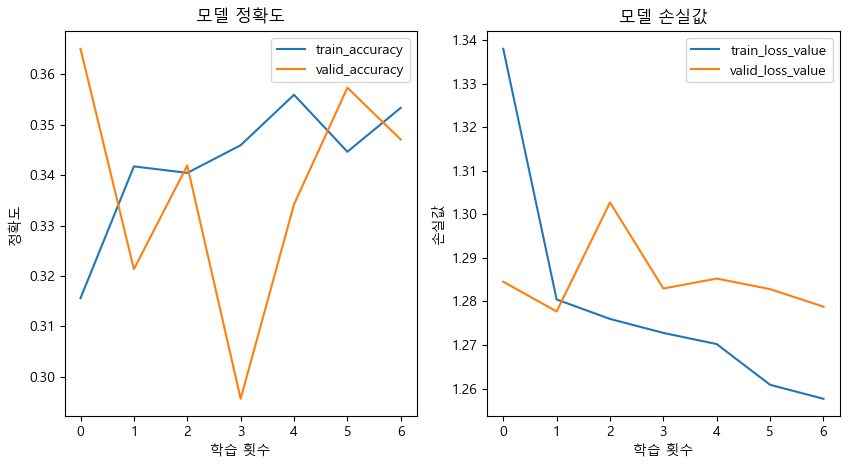

In [7]:
fit_my_cnn()
show_history('./model/my_cnn_history.csv')

1차 모델 훈련 결과 다소 절망적인 지표를 표출하고 있습니다. 과소적합인 모델로는 그/그녀에게 신뢰를 살 수 없습니다.

### 모델 튜닝(전이 학습, 생성기 수정, 미세 조정)
VGG19로 전이학습을 진행합니다. 그 이전에 생성기와 몇 파라미터를 수정하고, 전이학습에 미세조정을 병행합니다.

전이학습은 경우에 따라 미세조정(Fine tuning)과 같은 의미로 사용되기도 하지만, 특성추출과 미세조정 2가지로 세분화하여 1단계에서는 특성추출을 사용하고, 2단계에서 미세조정을 진행했습니다. 특성추출은 컨볼루션층의 파라미터는 고정시키고 완전연결층의 파라미터를 재학습시키는 것을 의미하고, 미세조정은 완전연결층과 더불어 컨볼루션층의 마지막 몇 개층 파라미터를 재학습시키는 것을 의미한다

In [10]:
input_shape = (300, 300, 3) # 150, 224
batch_size = 16 # 4, 8

# 생성기 수정 시도
train_datagen = ImageDataGenerator(
    preprocessing_function = tf.keras.applications.densenet.preprocess_input, # 0 ~ 1사이 값으로 조정하되, 각 채널은 ImageNet 데이터 세트에 대해 정규화
    width_shift_range=0.3,               
    zoom_range=0.2,                      
    horizontal_flip=True,
    fill_mode = 'nearest',
    shear_range = 0.2               
)

test_datagen = ImageDataGenerator(      
    preprocessing_function = tf.keras.applications.densenet.preprocess_input
)

train_generator = train_datagen.flow_from_directory( 
    train_dir,                 
    target_size = input_shape[:2],  
    batch_size = batch_size,      
    color_mode = 'rgb',           
    class_mode='categorical'        
)                                   

validation_generator = test_datagen.flow_from_directory(
    test_dir,                      
    target_size=input_shape[:2],    
    batch_size=batch_size,          
    color_mode='rgb',
    class_mode='categorical'        
)

def get_model(model):
    
    params = {'input_shape' : input_shape, 
              'include_top': False,  # Affine 계층을 포함시키지 않고 직접 구현하여 연결한다.
              'weights':'imagenet', # imagenet의 가중치 사용
              'pooling':'max',
              'classes':4}
    
    pretrained_model = model(**params) # **는 dictionary(params)내부의 키:값 쌍을 함수에 keyword 인자(input_shape = input_shape)로 전달합니다.
    
    for pretrained_layer in pretrained_model.layers[:23]: # 본래 미세 조정의 의미는 Affine 계층의 하이퍼 파라미터를 재학습함과 더불어 사전 학습 모델의 최상단의 일부를 재학습 하는 것을 의미하나
        pretrained_layer.trainable = False # 딱히 의미가 없어 그냥 전부 동결시켰습니다.
    
    inputs = pretrained_model.input
    
    # 완전연결신경망 구축(functional api method)
    x = tf.keras.layers.Flatten()(pretrained_model.output)
    x = tf.keras.layers.Dense(256, activation='relu')(x)
    x = tf.keras.layers.Dropout(rate=0.3)(x)
    outputs = tf.keras.layers.Dense(4, activation='softmax')(x)
    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    model.compile(optimizer="adam", loss='categorical_crossentropy', metrics=['acc'])
    
    return model

def fit_vgg19():
    model_check = ModelCheckpoint(filepath = "./model/VGG19/weights/weights.{epoch:02d}-{val_loss:.2f}.hdf5", monitor = "val_loss", save_best_only = True, mode = "min")
    reduce_lr = ReduceLROnPlateau(monitor = "val_loss", factor = 0.3, patience = 3, mode = "min")
    early_stop = EarlyStopping(monitor = "val_loss", patience = 5, mode = "min")
    logger = CSVLogger('./model/VGG19/VGG19_history.csv')
    
    model = get_model(tf.keras.applications.VGG19)
    model.fit(train_generator, epochs = num_epoch, steps_per_epoch = len(train_generator),
              validation_data = validation_generator, validation_steps = len(validation_generator),
              callbacks=[model_check, reduce_lr, early_stop, logger])

Found 3099 images belonging to 4 classes.
Found 389 images belonging to 4 classes.


Epoch 1/100
194/194 [==============================] - 41s 209ms/step - loss: 1.3709 - acc: 0.4369 - val_loss: 1.0656 - val_acc: 0.5476 - lr: 0.0010
Epoch 2/100
194/194 [==============================] - 40s 205ms/step - loss: 1.0881 - acc: 0.5376 - val_loss: 0.9053 - val_acc: 0.6144 - lr: 0.0010
Epoch 3/100
194/194 [==============================] - 44s 226ms/step - loss: 1.0040 - acc: 0.5795 - val_loss: 0.8672 - val_acc: 0.6427 - lr: 0.0010
Epoch 4/100
194/194 [==============================] - 43s 222ms/step - loss: 0.9456 - acc: 0.5941 - val_loss: 0.8347 - val_acc: 0.6555 - lr: 0.0010
Epoch 5/100
194/194 [==============================] - 43s 220ms/step - loss: 0.9202 - acc: 0.6163 - val_loss: 0.9083 - val_acc: 0.5913 - lr: 0.0010
Epoch 6/100
194/194 [==============================] - 44s 229ms/step - loss: 0.9030 - acc: 0.6299 - val_loss: 0.8051 - val_acc: 0.6581 - lr: 0.0010
Epoch 7/100
194/194 [==============================] - 43s 221ms/step - loss: 0.8671 - acc: 0.6431 - val_l

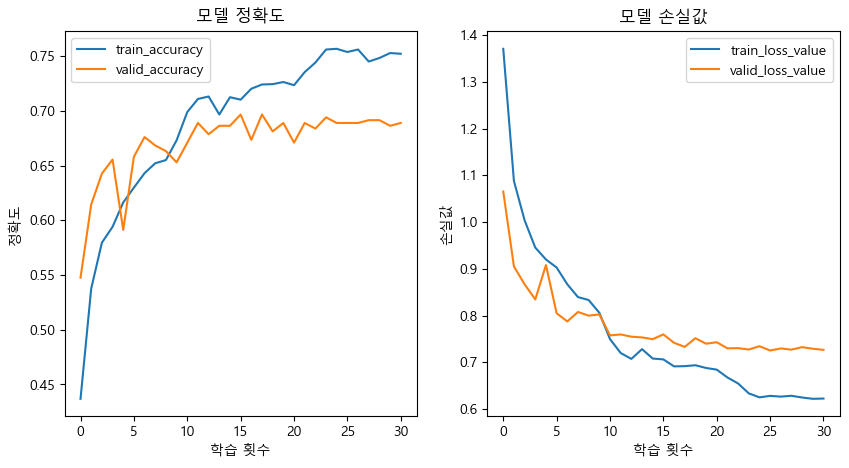

In [11]:
fit_vgg19()
show_history('./model/VGG19/VGG19_history.csv')

### 앙상블 학습(Model Chaining)
`VGG19 -> DenseNet201 -> 직접 구현 완전연결 신경망` 으로의 앙상블 학습을 진행하려 했으나, input data의 type 관련 정보를 찾지 못해서 진행하지 못했습니다.

### 안타깝게도...
모델의 성능이 좋지 않습니다. 하지만 그래도 성과는 어느 정도 있었습니다. 그/그녀에게 대답은 해줄 수 있겠군요.

마침 그/그녀에게 카톡이 옵니다.

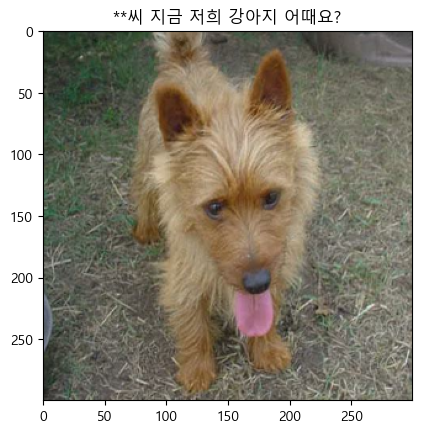

1/1 [==============================] - 0s 106ms/step
아 지금은 평온한 것 같네요 !


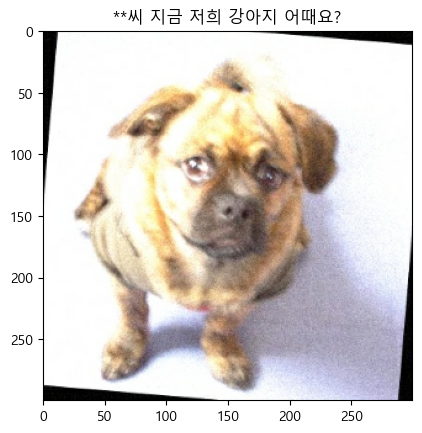

1/1 [==============================] - 0s 20ms/step
아 지금은 슬픈 것 같네요 !


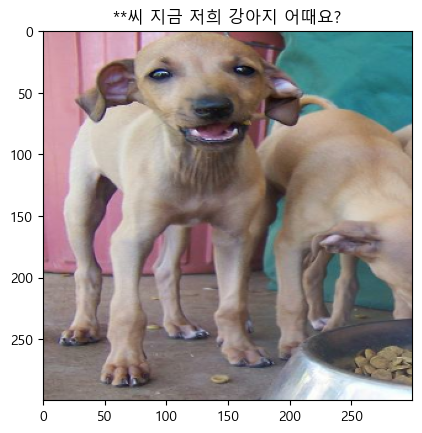

1/1 [==============================] - 0s 18ms/step
아 지금은 평온한 것 같네요 !


In [ ]:
import numpy as np

def read_image(path):                                   
    gfile = tf.io.read_file(path)                       
    image = tf.io.decode_image(gfile, dtype=tf.float32) 
    return image

model = get_model(tf.keras.applications.VGG19)
    
# 컴파일 한 뒤
model.compile(optimizer = "adam", loss = 'categorical_crossentropy', metrics = ['accuracy'])

# 학습했던 가중치를 적용한다.
model.load_weights('./model/VGG19/weights/weights.14-0.75.hdf5')

# 라벨값을 dict로 생성하여 결과 표출 시 사용한다.
labels = {0 : "화가 난 것", 1 : "행복한 것", 2 : "평온한 것", 3 : "슬픈 것"}

# 검증파일 경로 지정
data_path = glob('./dog_dataset_output/val/*/*.jpg')
np.random.shuffle(data_path)
for test_no in range(3):                    
    path = data_path[test_no]
    
    img = read_image(path)
    img = tf.image.resize(img, (300, 300))  # input size의 가로 세로의 크기와 동일하게 맞춘다.

    image = np.array(img)                   # inshow를 사용하기 위해서 ndarray로 전환
    plt.imshow(image, 'gray')
    plt.title('**씨 지금 저희 강아지 어때요?')
    plt.show()

    image = image[:, :, :]                     # 원본 이미지의 크기를 모두 가져오고(300, 300, 3)
    test_image = image[tf.newaxis, ...]        # 0번째 인덱스 값에 차원을 추가하며 (1, 300, 300, 3)의 shape으로 형전환
    pred = model.predict(test_image)           # predict함수를 사용하여 테스트 이미지 값을 유추
    num = np.argmax(pred)                      # 확률이 가장 높은 인덱스를 가져와서
    print(f"아 지금은 {labels[num]} 같네요 !") # dict의 키값으로 사용(라벨 표출)

### 느낀점

- 데이터 사이언티스트가 괜히 따로 있는 게 아니구나 싶은 생각이 요즘들어 자주 드는 것 같습니다. 데이터가 정말 중요하다는걸 새삼 깨닫습니다.
- 이전에는 전혀 감이 잡히지 않던 전이 학습 영역을 건드리면서 재밌는 프로젝트 기간이었던 것 같습니다.

### 의문점
- 전이학습 추이 그래프를 보면 마지막 부분에 격차가 벌어지면서 과대적합이 일어난 것으로 판단하는게 맞는 것인가?
- 그렇다면 완전 연결층에서 문제가 있는 것인가?

### 참고자료

논문(전이학습 참고용)
- https://www.kci.go.kr/kciportal/ci/sereArticleSearch/ciSereArtiView.kci?sereArticleSearchBean.artiId=ART002808862(반려견 자동 품종 분류를 위한 전이학습 효과 분석 (ResNet34/VGG16 간 비교))
- https://www.kci.go.kr/kciportal/ci/sereArticleSearch/ciSereArtiView.kci?sereArticleSearchBean.artiId=ART002759385(농작물 질병분류를 위한 전이학습에 사용되는 기초 합성곱신경망 모델간 성능 비교)

공식문서
- https://www.tensorflow.org/api_docs/python/tf/keras/applications(전이학습 모델 종류, 하이퍼 파라미터별 설명)

기타
- https://yellow-gangneng.tistory.com/123(검증 손실값과 훈련 손실값의 관계)
- https://keraskorea.github.io/posts/2018-10-24-little_data_powerful_model/(적은 데이터로도 높은 효율을 낼 수 있는 성능 개선 기법)
